# **Neural Networks DSM150-2022-OCT**
## **Course Work 2** : Neural networks application for Computer vision

### **Title** : Satellite Image - Image Segmentation [Building]

### Introduction
object detection in satellite imagery has exciting application, one of the many use cases involves detecting buildings for Network planning purposes in telecommunications deployement scenario. 
For the project the objective is to train a Neural network over satelite imagery available freely from Spacenet.ai. A Semantic segmentation technique will be used as the output of the model. 

### Data Source  
Data is available from Spacenet.ai as an AWS resource [https://spacenet.ai/rio-de-janeiro/]. The dataset contains 6,940 (400*400 pixel) setallite images of Rio de Jeneiro [3.45 GB] acompanied by its vector data in Geojson format [93 MB]
Following calls will download the required data sets:
  
  
aws s3 cp s3://spacenet-dataset/AOIs/AOI_1_Rio/processedData/processedBuildingLabels.tar.gz .
aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_3band.tar.gz .  
aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_8band.tar.gz   
aws s3 cp s3://spacenet-dataset/spacenet/SN1_buildings/tarballs/SN1_buildings_train_AOI_1_Rio_geojson_buildings.tar.gz .  

### Important References:  
https://github.com/adil-py/spacenet_building_detection  
https://medium.com/the-downlinq/getting-started-with-spacenet-data-827fd2ec9f53    
Deep Learning with Python 2nd Edition (Francois Chollet)


In [1]:
# import argparse
import os
from tqdm import tqdm


Defining the working directories

In [2]:
currentpath = os.getcwd()
lev2up = os.path.dirname(os.path.dirname(currentpath))
datadir = os.path.join(lev2up,"data")
rasterdir = os.path.join(datadir,"3band")
vectordir = os.path.join(datadir,"processedBuildingLabels\\vectordata\\geojson")
destdir = os.path.join(datadir,"buildingMaskImages")
splitdir = os.path.join(datadir,"dataSplit")
maskdir = os.path.join(datadir,"buildingMaskImages")
print(vectordir)

c:\Users\toadi\Documents\GitHub\spacenet_building_detection\data\processedBuildingLabels\vectordata\geojson


Function for Converting the Vector data for each image into its corresponding Mask image

In [3]:
# Add create_poly_mask

# Reference: 
# https://medium.com/the-downlinq/getting-started-with-spacenet-data-827fd2ec9f53
# https://gist.github.com/avanetten/b295e89f6fa9654c9e9e480bdb2e4d60#file-create_building_mask-py

from osgeo import gdal, ogr
from PIL import Image
import numpy as np
import os
import random


def create_poly_mask(rasterSrc, vectorSrc, npDistFileName='', 
							noDataValue=0, burn_values=1):

	'''
	Create polygon mask for rasterSrc,
	Similar to labeltools/createNPPixArray() in spacenet utilities
	'''
	
	## open source vector file that truth data
	source_ds = ogr.Open(vectorSrc)
	source_layer = source_ds.GetLayer()

	## extract data from src Raster File to be emulated
	## open raster file that is to be emulated
	srcRas_ds = gdal.Open(rasterSrc)
	cols = srcRas_ds.RasterXSize
	rows = srcRas_ds.RasterYSize

	if npDistFileName == '':
		dstPath = ".tmp.tiff"
	else:
		dstPath = npDistFileName

	## create First raster memory layer, units are pixels
	# Change output to geotiff instead of memory 
	memdrv = gdal.GetDriverByName('GTiff') 
	dst_ds = memdrv.Create(dstPath, cols, rows, 1, gdal.GDT_Byte, 
						   options=['COMPRESS=LZW'])
	dst_ds.SetGeoTransform(srcRas_ds.GetGeoTransform())
	dst_ds.SetProjection(srcRas_ds.GetProjection())
	band = dst_ds.GetRasterBand(1)
	band.SetNoDataValue(noDataValue)    
	gdal.RasterizeLayer(dst_ds, [1], source_layer, burn_values=[burn_values])
	dst_ds = 0

	mask_image = Image.open(dstPath)
	mask_image = np.array(mask_image)

	if npDistFileName == '':
		os.remove(dstPath)
		
	return mask_image

Function for writing all mask images on Drive

In [4]:
def build_labels(src_raster_dir, src_vector_dir, dst_dir):
	
	os.makedirs(dst_dir, exist_ok=True)

	file_count = len([f for f in os.walk(src_vector_dir).__next__()[2] if f[-8:] == ".geojson"])

	print("[INFO] Found {} geojson files. Preparing building mask images...".format(file_count))

	for idx in tqdm(range(1, file_count + 1)):

		src_raster_filename = "3band_AOI_1_RIO_img{}.tif".format(idx)
		src_vector_filename = "Geo_AOI_1_RIO_img{}.geojson".format(idx)

		src_raster_path = os.path.join(src_raster_dir, src_raster_filename)
		src_vector_path = os.path.join(src_vector_dir, src_vector_filename)
		dst_path = os.path.join(dst_dir, src_raster_filename)

		create_poly_mask(
			src_raster_path, src_vector_path, npDistFileName=dst_path, 
			noDataValue=0, burn_values=255
		)


# if __name__ == "__main__":

# 	parser = argparse.ArgumentParser()

# 	parser.add_argument('src_raster_dir', help='Root directory for raster files (.tif)')
# 	parser.add_argument('src_vector_dir', help='Root directory for vector files (.geojson)')
# 	parser.add_argument('dst_dir', help='Output directory')

# 	args = parser.parse_args()

# 	build_labels(args.src_raster_dir, args.src_vector_dir, args.dst_dir)

Call for the Mask creation function

In [50]:
build_labels(rasterdir,vectordir,destdir)

[INFO] Found 6940 geojson files. Preparing building mask images...


100%|██████████| 6940/6940 [03:54<00:00, 29.59it/s]


Image to Vector conversion

In [5]:
from tensorflow import keras

In [159]:
np.unique(label_imgss) # Label images or masks are categorical, 1=Building, 0=Background

array([0, 1], dtype=uint8)

Image to Vector conversion with image resizing to 200*200 pixels for faster training cycle

In [6]:
# Shffling, Rescaling and converting to vectors - data readiness for the model
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt
import random
import cv2

seed = 333


labelPaths = []
for fname in os.listdir(maskdir):
    labelPaths.append(fname) 

inputPaths = []
for fname in os.listdir(rasterdir):
    inputPaths.append(fname)

random.Random(seed).shuffle(inputPaths)                          # random shuffle with a fixed seed, same for inputs and labels 
random.Random(seed).shuffle(labelPaths)

def path_to_input_image_lr(path):
      lrimg_ = cv2.imread(path,cv2.IMREAD_UNCHANGED)
      lrimg = cv2.resize(lrimg_, (200, 200))                     # resizing to 200*200
      lrimgA = img_to_array(lrimg)
      return lrimgA

def path_to_label_image_lr(path):
      lrimg_ = cv2.imread(path,cv2.IMREAD_GRAYSCALE)              # reading as gray scale
      lrimg = cv2.resize(lrimg_, (200, 200))                      # resizing to 200*200
      lrimgA = img_to_array(lrimg)
      return lrimgA

img_size_lr = (200,200)
num_imgs = len(labelPaths)

input_imgss_lr = np.zeros((num_imgs,)+img_size_lr+(3,),dtype="float32")
label_imgss_lr = np.zeros((num_imgs,)+img_size_lr+(1,),dtype="uint8")

for i in range(num_imgs):
    input_imgss_lr[i] = path_to_input_image_lr(os.path.join(rasterdir,inputPaths[i]))
    label_imgss_lr[i] = path_to_label_image_lr(os.path.join(maskdir,labelPaths[i]))

label_imgss_lr[label_imgss_lr>0]=1                                # ensuring all non 0 values are 1, reprenting buildings


Sample representation of the Input Image and the accompanying mask  
The output of the Neural model is to predict the buildings by convoluting on per pixel basis to identify if it belongs to a building or not

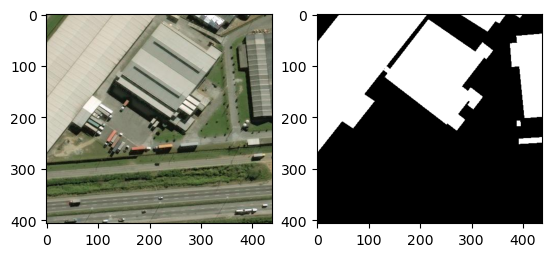

In [7]:
fig, ax =plt.subplots(1,2)
ax[0].imshow(load_img(os.path.join(rasterdir,inputPaths[300])))
ax[1].imshow(load_img(os.path.join(maskdir,labelPaths[300])))


Using a 70:15:15 split for Train, Test and Validation

In [8]:
num_train = int(len(labelPaths)*0.70) # 70:15:15 ; train, test, validation
num_test = int(len(labelPaths)*0.15)

In [130]:
# #Train, Test and Validation Splits

# train_x = input_imgss[:num_train]
# train_y = label_imgss[:num_train]
# val_x = input_imgss[-num_test:]
# val_y = label_imgss[-num_test:]
# test_x = input_imgss[-(num_test*2):-num_test]
# test_y = label_imgss[-(num_test*2):-num_test]

In [9]:
#Train, Test and Validation Splits - Low Res

train_x_lr = input_imgss_lr[:num_train]
train_y_lr = label_imgss_lr[:num_train]
val_x_lr = input_imgss_lr[-num_test:]
val_y_lr = label_imgss_lr[-num_test:]
test_x_lr = input_imgss_lr[-(num_test*2):-num_test]
test_y_lr = label_imgss_lr[-(num_test*2):-num_test]

In [12]:
train_y_lr.shape

(4858, 200, 200, 1)

Model Definition  
[Reference : DLP 2nd edition: Chapter 9]

In [11]:
from tensorflow.keras import layers
from tensorflow import keras

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size+(3,))
    x = layers.Rescaling(scale = 1./255) (inputs)

    x = layers.Conv2D(64,3, strides=2, activation="relu", padding="same") (x)
    x = layers.Conv2D(64,3, activation="relu", padding="same") (x)
    x = layers.Conv2D(128,3, strides=2, activation="relu", padding="same") (x)
    x = layers.Conv2D(128,3, activation="relu", padding="same") (x)    
    x = layers.Conv2D(256,3, strides=2, activation="relu", padding="same") (x)
    x = layers.Conv2D(256,3, activation="relu", padding="same") (x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same") (x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2) (x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same") (x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2) (x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same") (x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2) (x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same") (x)

    model = keras.Model(inputs, outputs)
    return model  

model_lr = get_model(img_size=img_size_lr,num_classes=2)
model_lr.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

Model Compilation and fitting 

In [ ]:
# Not used in the final Run
# model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

# callbacks = [

#     keras.callbacks.ModelCheckpoint("oxford_segmentation.karas",
#                                     save_best_only=True)
# ]

# history_a = model.fit(train_x,train_y,
#                     epochs=1, # 50
#                     callbacks=callbacks,
#                     batch_size=16,  #64
#                     validation_data = (val_x,val_y))



304/304 [==============================] - ETA: 0s - loss: 0.2572

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


304/304 [==============================] - 2824s 9s/step - loss: 0.2572 - val_loss: 0.2014


In [12]:
model_lr.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [

    keras.callbacks.ModelCheckpoint("oxford_segmentation.karas",
                                    save_best_only=True)
]

In [13]:
history = model_lr.fit(train_x_lr,train_y_lr,
                    epochs=20, # 50
                    callbacks=callbacks,
                    batch_size=30   ,  #64
                    validation_data = (val_x_lr,val_y_lr))


Epoch 1/20
162/162 [==============================] - ETA: 0s - loss: 0.3224

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 771s 5s/step - loss: 0.3224 - val_loss: 0.2248
Epoch 2/20
162/162 [==============================] - ETA: 0s - loss: 0.2247

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 760s 5s/step - loss: 0.2247 - val_loss: 0.1984
Epoch 3/20
162/162 [==============================] - 769s 5s/step - loss: 0.2013 - val_loss: 0.2000
Epoch 4/20
162/162 [==============================] - ETA: 0s - loss: 0.1892

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 765s 5s/step - loss: 0.1892 - val_loss: 0.1822
Epoch 5/20
162/162 [==============================] - ETA: 0s - loss: 0.1825

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 757s 5s/step - loss: 0.1825 - val_loss: 0.1801
Epoch 6/20
162/162 [==============================] - 710s 4s/step - loss: 0.1739 - val_loss: 0.1954
Epoch 7/20
162/162 [==============================] - ETA: 0s - loss: 0.1685

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 711s 4s/step - loss: 0.1685 - val_loss: 0.1669
Epoch 8/20
162/162 [==============================] - ETA: 0s - loss: 0.1640

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 714s 4s/step - loss: 0.1640 - val_loss: 0.1649
Epoch 9/20
162/162 [==============================] - 712s 4s/step - loss: 0.1589 - val_loss: 0.1653
Epoch 10/20
162/162 [==============================] - 709s 4s/step - loss: 0.1548 - val_loss: 0.1679
Epoch 11/20
162/162 [==============================] - ETA: 0s - loss: 0.1520

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 712s 4s/step - loss: 0.1520 - val_loss: 0.1459
Epoch 12/20
162/162 [==============================] - 713s 4s/step - loss: 0.1470 - val_loss: 0.1482
Epoch 13/20
162/162 [==============================] - ETA: 0s - loss: 0.1452

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 718s 4s/step - loss: 0.1452 - val_loss: 0.1417
Epoch 14/20
162/162 [==============================] - 714s 4s/step - loss: 0.1407 - val_loss: 0.1576
Epoch 15/20
162/162 [==============================] - ETA: 0s - loss: 0.1379

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 715s 4s/step - loss: 0.1379 - val_loss: 0.1355
Epoch 16/20
162/162 [==============================] - ETA: 0s - loss: 0.1365

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 716s 4s/step - loss: 0.1365 - val_loss: 0.1327
Epoch 17/20
162/162 [==============================] - 717s 4s/step - loss: 0.1331 - val_loss: 0.1357
Epoch 18/20
162/162 [==============================] - 717s 4s/step - loss: 0.1313 - val_loss: 0.1332
Epoch 19/20
162/162 [==============================] - ETA: 0s - loss: 0.1293

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 718s 4s/step - loss: 0.1293 - val_loss: 0.1290
Epoch 20/20
162/162 [==============================] - ETA: 0s - loss: 0.1271

INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


INFO:tensorflow:Assets written to: oxford_segmentation.karas\assets


162/162 [==============================] - 719s 4s/step - loss: 0.1271 - val_loss: 0.1279


In [435]:
# a = np.argmax(mask,axis=-1)
b = mask[:,:,1]
b[b[:]>0.3]=0.9
mask[:,:,1] = b

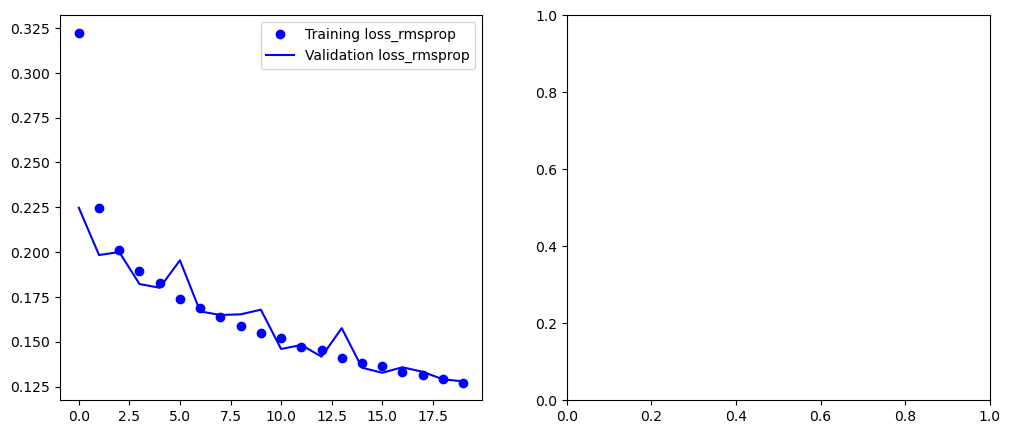

In [14]:
xa = range(len(history.epoch))
fig, ax =plt.subplots(1,2, figsize=(12,5))
ax[0].plot(xa,history.history['loss'],'bo', label='Training loss_rmsprop')
ax[0].plot(xa,history.history['val_loss'],'b', label='Validation loss_rmsprop')
ax[0].legend()

1/1 [==============================] - 0s 114ms/step


Text(0.5, 1.0, 'Deep Learning Output')

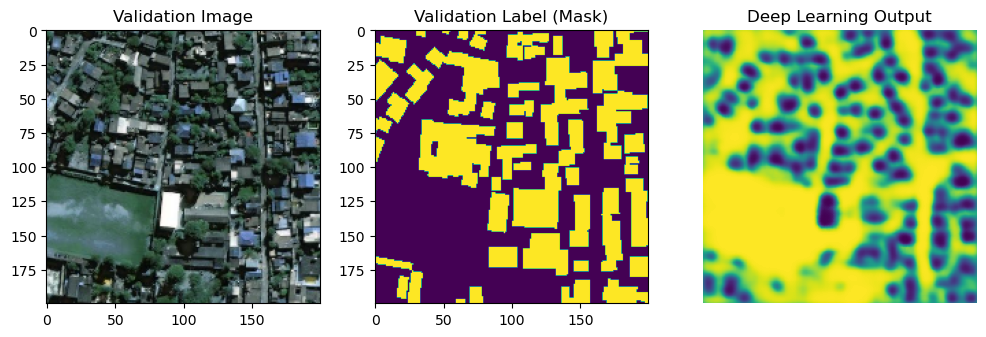

In [18]:
from tensorflow.keras.utils import array_to_img

i=626
test_i = val_x_lr[i]

mask = model_lr.predict(np.expand_dims(test_i,0)) [0]

fig, ax =plt.subplots(1,3, figsize=(12,5))
ax[0].imshow(array_to_img(test_i))
def display_maska(pred,i):
    # pred = np.argmax(pred,axis=-1)
    # pred.reshape(200,200,1)
    pred *= 127
    plt.axis("off")
    ax[i].imshow(pred[:,:,0])

display_maska(mask,2)
display_maska(val_y_lr[i],1)
ax[0].set_title("Validation Image")
ax[1].set_title("Validation Label (Mask)")
ax[2].set_title("Deep Learning Output")


### Project Output Results and Shortcomings  

Output of the model sucessfully represents a low resolution identification of building region, owing to the limitation in compute power bigger convolution layers were unable to be tested.  
Secoundly the problem at hand is suitable for an Instance segmentation where each individual building is segmented to create a similar output as the Input mask.
This type of segmentation is ideally achieved using the Unet convolution neural network, which was outside the scope of this course work. The work on this project will continue to implemnt a Unet styled implemntation in Keras.